# 02806 Social Dataanalysis - Project Assignment B

# Where is it safe to eat in New York City?


## Table of contents
1. Motivation
2. Data preperation and basic stats
3. Theory and machine learning models
4. Visualisations and explanation of the website
5. Discussion and conclusion

## 1 - Motivation

As we first glanced on this dataset, we thought it would be interesting to examine how a person can know whether a restaurant is likely to be *hygienic* and a *safe* place to eat. Whenever you see a restaurant you immediately know something about it such as its location and which kind of food it serves. With most people having constant access to the internet, you may also have access to user reviews for example from **Yelp.com** which containts a score and user reviews of a restaurant. With this in mind, we decided to investigate how a tourist could make informed decisions about where to eat safe food with these information available. And if we ever were to go to NYC we hopefully, by the end of this analysis, know which places to avoid and which places to welcome. So the overall goal is to predict and investigate which restaurants are safe to eat at with limited information that a tourist typically have. Lastly, we decided to look into Michelin restaurants, since this information typically also is easily available for a tourist due to the associated fame that comes with having Michelin stars.

The main dataset we need to make this analysis possible is the New York City restaurant inspection results which can be found here: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/xx67-kt59. This contains alot of information about the particular restaurant and also a score that summarises how the hygiene is in this restaurant. There are repeated inspections for each restaurant, so we have alot of information available. This dataset is combined with a second one: X and Y coordinates. We do this is order to have some quantitative information about the placing of the restaurant. The third and last dataset is the **Yelp.com** dataset. Here we obtain the score for each restaurant among other variables. All this will be explained in details later.

The sizes of the three dataset are given below
* The total size of the inspection dataset is: 169 MB
* The total size of the coordinates dataset is: 10 MB
* The total size of the Yelp.com dataset is: 4.7 MB


A detailed explanation of the grades and scores can be found here: http://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf

## 2 - Basic Stats

In this section we will provide a detailed explanation of our initial data manipulation and exploration. We shall do this by producing several graphics acompanied by descriptions of our findings.

### 2.1 - Data preparation

We describe the process of cleaning the dataset in this section.

In [2]:
# Preamble
import numpy as np
import pandas as pd
import geoplotlib
import datetime
import math
import matplotlib.pyplot as plt
import urllib, urllib2, json
import statsmodels.api as sm
from collections import defaultdict
from geoplotlib.utils import read_csv, BoundingBox
from scipy import stats
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from __future__ import division
from IPython.display import Image
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator
from sklearn import preprocessing
from sklearn import tree
from IPython.display import IFrame
from sknn.mlp import Regressor, Layer
from __future__ import division

%matplotlib inline

# Pandas preamble
# Make the graphs a bit prettier, and bigger
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60) 
pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use('ggplot')

We import the inspection dataset and the coordinates. Detailed information about how we obtained the coordinates are given later on. We convert the dates to suitable datetime-formats. For the cleaning process we remove records with negative scores, since we cannot find any information about how and why these have been given (See e.g. the link to the report provided above). Also, we remove observations that do not have a restaurant name, score or a location (coordinates). Lastly, we sort the dataset by id.

In [4]:
df = pd.read_csv('./DOHMH_New_York_City_Restaurant_Inspection_Results.csv')
address = pd.read_csv('NY_Restuarant_Address.csv')
df['lat'] = address['lat']
df['lon'] = address['lng']

# Convert to datetime
df['GRADE DATE'] =  pd.to_datetime(df['GRADE DATE'], format='%m/%d/%Y')
df['INSPECTION DATE'] =  pd.to_datetime(df['INSPECTION DATE'], format='%m/%d/%Y')
df['RECORD DATE'] =  pd.to_datetime(df['RECORD DATE'], format='%m/%d/%Y')

# remove rows with negative scores
df = df.drop(df[df['SCORE'] < 0].index)
# keep only data with restaurant name, score and known location
df = df.dropna(subset=['DBA', 'SCORE', 'lat', 'lon'])
# sort data
df = df.sort_values(by=['CAMIS', 'INSPECTION DATE'], ascending=[True, False])

Notice that we still haven't combined these datasets with the Yelp dataset, but we shall do this later on.

The variable names are given below. Most of them are self-explanatory. The CAMIS variable is a unique ID, DBA is the name of the restaurant, BORO is the borough of NYC, ACTION is a string containing some information about the violations and VIOLATION CODE contains a code that can be looked up in the above linked report.

In [5]:
list(df)

['CAMIS',
 'DBA',
 'BORO',
 'BUILDING',
 'STREET',
 'ZIPCODE',
 'PHONE',
 'CUISINE DESCRIPTION',
 'INSPECTION DATE',
 'ACTION',
 'VIOLATION CODE',
 'VIOLATION DESCRIPTION',
 'CRITICAL FLAG',
 'SCORE',
 'GRADE',
 'GRADE DATE',
 'RECORD DATE',
 'INSPECTION TYPE',
 'lat',
 'lon']

Now, since almost all restaurants have multiple inspections, we need to do some aggregation. We would like to have one observation for each restaurant, so we average each score across the multiple inspections. This reduces our dataset to 24877 observations.

In [6]:
df_unique = df.drop_duplicates(subset=['CAMIS'])
df_unique["AVGSCORE"] = (df[["CAMIS","SCORE"]].groupby("CAMIS").mean()["SCORE"]).tolist()
print "Size of dataset: ", len(df_unique)

Size of dataset:  24877


A snippet of the cleaned dataset is shown below

In [7]:
df_unique.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,lat,lon,AVGSCORE
0,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,2016-02-18,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,10,A,2016-02-18,2016-04-11,Cycle Inspection / Initial Inspection,40.848432,-73.856035,19.333333
14,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225,7182875005,Hamburgers,2015-05-07,Violations were cited in the following area(s).,04A,Food Protection Certificate not held by superv...,Critical,12,A,2015-05-07,2016-04-11,Cycle Inspection / Initial Inspection,40.662921,-73.961727,14.105263
33,30191841,DJ REYNOLDS PUB AND RESTAURANT,MANHATTAN,351,WEST 57 STREET,10019,2122452912,Irish,2015-09-21,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,8,A,2015-09-21,2016-04-11,Cycle Inspection / Re-inspection,40.767821,-73.984981,9.666667
42,40356018,RIVIERA CATERER,BROOKLYN,2780,STILLWELL AVENUE,11224,7183723031,American,2015-06-05,Violations were cited in the following area(s).,08C,Pesticide use not in accordance with label or ...,Not Critical,4,A,2015-06-05,2016-04-11,Cycle Inspection / Initial Inspection,40.579505,-73.982420,5.666667
48,40356151,BRUNOS ON THE BOULEVARD,QUEENS,8825,ASTORIA BOULEVARD,11369,7183350505,American,2015-05-29,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,12,A,2015-05-29,2016-04-11,Cycle Inspection / Re-inspection,40.764312,-73.880383,21.388889


### 2.2 - Adress to longitude and lattitude

Since the original dataset did not contain lattitude and longitute coordinates, we decided to find them ourselves. Below we provide the code with which we have done so using the Google Maps API through the function

In [8]:
def decode_address_to_coordinates(address):
    """Function for fetching latitude/longitude coordinates
    source: http://stackoverflow.com/questions/15285691/googlemaps-api-address-to-coordinates-latitude-longitude"""
    params = {
            'address' : address,
            'sensor' : 'false',
    }  
    url = 'http://maps.google.com/maps/api/geocode/json?' + urllib.urlencode(params)
    response = urllib2.urlopen(url)
    result = json.load(response)
    try:
            return result['results'][0]['geometry']['location']
    except:
            return None

and then all addresses are fetched in the for-loop. Note that the for loop takes are very long time to run.

In [ ]:
df_address = pd.DataFrame(columns=['lat','lng'], index=df.index)
address_prev = ""
for i in df_address.index:
    # create address
    address = "" if pd.isnull(df["BUILDING"][i]) else df["BUILDING"][i] + ", "
    address += df["STREET"][i] + ", NY " + str(df["ZIPCODE"][i])
    # get coordinates and store them in address_prev dataFrame
    if address == address_prev:
        df_address.loc[i] = df_address.loc[i-1]
    else:
        df_address.loc[i] = pd.Series(decode_address_to_coordinates(address))
        time.sleep(.5)
    address_prev = address

And this has been saved to a .CSV file, which have been loaded above.

### 2.3 - Yelp.com dataset

In order to obtain more information about each restaurant in our violation dataset, we make use of the Yelp API. Yelp is an online rating platform for consumers to access and rate different restaurants, bars etc. The Yelp API is easy accessible through Python.

We start by gaining access by user specific keys. These are private, so we shall not present them here, but it might look something like this

In [9]:
consumer_key = "safe_consumer_key"
consumer_secret = "safe_consumer_secret"
token = "safe_token"
token_secret = "safe_token_secret"

Then open the API access:

In [10]:
auth = Oauth1Authenticator(
    consumer_key=consumer_key,
    consumer_secret=consumer_secret,
    token=token,
    token_secret=token_secret
)

client = Client(auth)

It is not completely obvious how we should match the two datasets, since there are no unique identifier. The most obvious is probably telephone number, since this should be unique. There might be some restaurants that have changed phone number since the inspection dataset was been published, or some may have reported one number to Yelp.com and a different to the inspectors. We cannot handle such inconveniences, so we match only by phone number. We do this below. The code explained in a few lines: We loop over all the restaurants and then use the built-in API function phone_search. If a match is found we grab the first and best result (the API might return multiple matches, but it is always the first in the list that is the *best*), then extract the variables of interest and save it.

In [ ]:
phone_list = df_unique[['CAMIS','PHONE']]
results = [[]]*len(df_unique)
result = []
NAs = []
i = -1
for phone, camis in phone_list[["PHONE","CAMIS"]].itertuples(index=False):
    i += 1
    response = client.phone_search(phone, **params)
    if len(response.businesses) > 0 :
        business = response.businesses[0] # Grab the first and best search result
        result = [camis, phone, business.name, business.id, business.rating,
                  business.is_closed, business.review_count, business.snippet_text,
                  business.menu_provider, business.menu_date_updated, business.is_claimed]
        
        # Check if neighborhood information is available
        # If it is, grab the first element of the list
        # Otherwise write NA
        if business.location.neighborhoods is not None:
            result.extend([business.location.neighborhoods[0]])
        else:
            result.extend(["NaN"])
    
        results[i] = result
        result = []
    else:
        NAs.append([camis,phone])
    time.sleep(0.5)

Running the above for loop takes a great deal of time. We have saved the data obtained from the for-loop in a .csv file which we here load and inspect the attributes

In [11]:
df_yelp = pd.read_csv("yelp.csv")
print "Variables: "
print list(df_yelp)
print "Size of dataset: ", len(df_yelp)

Variables: 
['CAMIS', 'PHONE', 'NAME_YELP', 'ID_YELP', 'RATING_YELP', 'IS_CLOSED_YELP', 'REVIEW_COUNT_YELP', 'SNIPPET_TEXT_YELP', 'MENU_PROVIDER_YELP', 'MENU_DATE_UPDATED_YELP', 'IS_CLAIMED_YELP', 'NEIGHBORHOODS_1_YELP']
Size of dataset:  24877


We put the possibly interesting attributes in the restaurant data

In [12]:
df_unique['RATING_YELP'] = df_yelp['RATING_YELP']
df_unique['REVIEW_COUNT_YELP'] = df_yelp['REVIEW_COUNT_YELP']
df_unique['IS_CLOSED_YELP'] = df_yelp['IS_CLOSED_YELP']
df_unique['IS_CLAIMED_YELP'] = df_yelp['IS_CLAIMED_YELP']
df_unique['MENU_PROVIDER_YELP'] = df_yelp['MENU_PROVIDER_YELP']

A snippet of the entire dataset is shown below

In [13]:
df_unique.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,lat,lon,AVGSCORE,RATING_YELP,REVIEW_COUNT_YELP,IS_CLOSED_YELP,IS_CLAIMED_YELP,MENU_PROVIDER_YELP
0,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,2016-02-18,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,10,A,2016-02-18,2016-04-11,Cycle Inspection / Initial Inspection,40.848432,-73.856035,19.333333,4.5,22,False,False,NaN
14,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225,7182875005,Hamburgers,2015-05-07,Violations were cited in the following area(s).,04A,Food Protection Certificate not held by superv...,Critical,12,A,2015-05-07,2016-04-11,Cycle Inspection / Initial Inspection,40.662921,-73.961727,14.105263,NaN,NaN,NaN,NaN,NaN
33,30191841,DJ REYNOLDS PUB AND RESTAURANT,MANHATTAN,351,WEST 57 STREET,10019,2122452912,Irish,2015-09-21,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,8,A,2015-09-21,2016-04-11,Cycle Inspection / Re-inspection,40.767821,-73.984981,9.666667,3.5,39,False,True,NaN
42,40356018,RIVIERA CATERER,BROOKLYN,2780,STILLWELL AVENUE,11224,7183723031,American,2015-06-05,Violations were cited in the following area(s).,08C,Pesticide use not in accordance with label or ...,Not Critical,4,A,2015-06-05,2016-04-11,Cycle Inspection / Initial Inspection,40.579505,-73.982420,5.666667,2.5,8,False,False,NaN
48,40356151,BRUNOS ON THE BOULEVARD,QUEENS,8825,ASTORIA BOULEVARD,11369,7183350505,American,2015-05-29,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,12,A,2015-05-29,2016-04-11,Cycle Inspection / Re-inspection,40.764312,-73.880383,21.388889,2.5,2,False,False,NaN


### 2.4 - Initial data exploration
#### 2.4.1 - Distribution of scores

We start off by computing an average score for all restaurants. This average score will be used for benchmarking other restaurants. Since the same restaurant or eatery is subject to several inspections during our considered period, we thought it wise to compute the score average by first finding averages for restaurants or chains and then computing a global mean value.

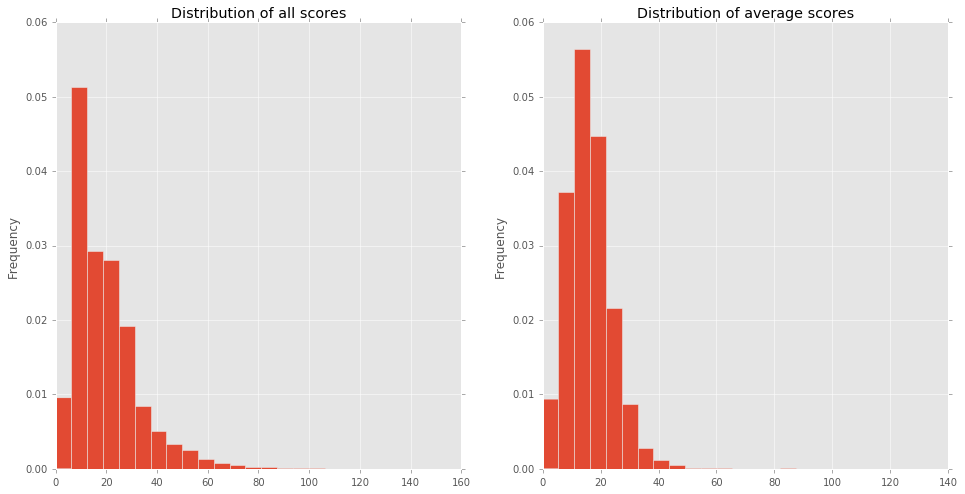

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes = axes.ravel()
fig.set_figheight(8)
fig.set_figwidth(16)
_ = df['SCORE'].hist(normed=1,bins=25,ax=axes[0]) # Save in unused variable to suppres output
_ = df_unique['AVGSCORE'].hist(normed=1,bins=25,ax=axes[1])
_ = axes[0].set_ylabel('Frequency')
_ = axes[1].set_ylabel('Frequency')
_ = axes[0].set_title('Distribution of all scores')
_ = axes[1].set_title('Distribution of average scores')

We notice that the distribution is right skewed in both cases, and there are some restaurants with some very high scores compared to the center of the distributions. The grand average score of the restaurants is

In [15]:
Mean=np.mean(df_unique['AVGSCORE'])
print "Grand average score: ", Mean

Grand average score:  16.1013482377


The cuisines are of particular interest, since it is immediately known to the tourist which kind of food is served at this particular restaurant. The different types of cuisines descriptions are:

In [16]:
df_unique['CUISINE DESCRIPTION'].value_counts()

American                                                            6093
Chinese                                                             2391
CafÃ©/Coffee/Tea                                                    1364
Pizza                                                               1166
Italian                                                             1052
Latin (Cuban, Dominican, Puerto Rican, South & Central American)     880
Mexican                                                              814
Japanese                                                             788
Bakery                                                               718
Caribbean                                                            649
Spanish                                                              605
Donuts                                                               497
Pizza/Italian                                                        462
Sandwiches                                         

That's a lot! There are a total of 84 different cuisine descriptions.

To ease things a bit, we make a new cuisine variable where we have grouped the different cuisine descriptions together. First we create a dict defining the groupings:

In [17]:
cuisine_tuple_dict = { 
    # American
    ('American','Californian','Creole', 'Cajun','Creole/Cajun','Southwestern', 'Hawaiian','Polynesian', 'Barbecue', 'Steak'): 'American',
    # Chinese
    ('Chinese', 'Chinese/Cuban') : 'Chinese',
    # Fast Food
    ('Pizza', 'Hotdogs', 'Hamburgers') : 'Fast Food',
    # Italian
    ('Italian', 'Pizza/Italian') : 'Italian',
    # Cafe
    ('Caf\xc3\x83\xc2\xa9/Coffee/Tea',) : 'Cafe',
    # Latin
    ('Latin (Cuban, Dominican, Puerto Rican, South & Central American)', 'Mexican', 'Chilean', 'Tex-Mex', 'Brazilian', 'Polynesian', 'Peruvian') : 'Latin',
    # Asian
    ('Asian', 'Japanese', 'Korean', 'Russian', 'Thai', 'Iranian', 'Indian', 'Middle Eastern', 'Indonesian', 'Filipino', 'Vietnamese/Cambodian/Malaysia', 'Afghan', 'Pakistani', 'Armenian', 'Bangladeshi') : 'Asian',
    # African
    ('African', 'Soul Food', 'Ethiopian', 'Egyptian', 'Moroccan') : 'African',
    # European
    ('Eastern European', 'Continental', 'Polish', 'Czech', 'Irish', 'German', 'English', 'Scandinavian') : 'European',
    # Bakery
    ('Bakery',) : 'Bakery',
    # Mediterranean
    ('Mediterranean', 'French', 'Portuguese', 'Spanish', 'Greek', 'Turkish') : 'Mediterranean',
    # Seafood
    ('Seafood',) : 'Seafood',
}
cuisine_dict = {}
for k, v in cuisine_tuple_dict.items():
    for key in k:
        cuisine_dict[key] = v
cuisine_dict = defaultdict(lambda: "Other", cuisine_dict)

Let's then create the new cuisine variable

In [18]:
df_unique["CUISINE"] = [cuisine_dict[cuisine] for cuisine in df_unique['CUISINE DESCRIPTION']]
df_unique['CUISINE'].value_counts()

American         6286
Other            4360
Asian            2517
Chinese          2412
Latin            1947
Fast Food        1628
Italian          1514
Mediterranean    1398
Cafe             1364
Bakery            718
European          411
Seafood           162
African           160
Name: CUISINE, dtype: int64

All right, now we only have 13 cuisine types. Let's take a look at their mean scores:

In [19]:
df_unique[["CUISINE", "AVGSCORE"]].groupby("CUISINE").mean().sort_values(["AVGSCORE"])

,AVGSCORE
CUISINE,
Cafe,12.892451
Other,14.501292
American,15.462577
Fast Food,15.615499
Bakery,16.061079
Seafood,16.385659
European,16.438845
Italian,17.124801
Mediterranean,17.184863


Cafe cuisine has a very low score. This is most likely because there are not that much food involved here. It is mostly tea and coffee. For the same reason the Other category also gets a low score because this category is dominated by restaurants serving food such as "Donuts", "Sandwiches", "Juice, Smoothies, Fruit Salads" and "Ice Cream".

Other than that there certainly appears to be a pattern with <b>foreign food scoring poorly </b>. In the bottom we have the African cuisine - a type of cuisine in which hands are used a lot during the cooking.

#### 2.4.2 - Comparing famous restaurants to the average score (AFVENT NINA)

Two separate articles seem to support a list of *very exclusive* restaurants in New York city. These articles are:
http://www.grubstreet.com/2015/09/michelin-stars-2016-new-york-city.html (NYC restaurants with Michelin Stars *https://en.wikipedia.org/wiki/Michelin_Guide) and a list of the most expensive restaurants in NYC (http://gonyc.about.com/od/restaurants/ss/Most-Expensive-New-York-City-Restaurants.htm#step8).

We decided to look at these "famous" restaurants and see if we could find interesting correlations.

Below we manually define three lists that contains the names of the restaurants with three, two and one star(s), respectively.

In [20]:
Michelin_3s =["BROOKLYN FARE KITCHEN","ELEVEN MADISON PARK","JEAN GEORGES", "LE BERNARDIN", "BARMASA / MASA", "PER SE"]
Michelin_2s =["AQUAVIT","ATERA", "BLANCA/SEVERED HEADS", "DANIEL", "MAREA RESTAURANT", "THE MODERN", "MOMOFUKU KO"
,"SOTO JAPANESE RESTAURANT"]
Michelin_1s =["TAKE ROOT", "TELEPAN", "TEMPURA MATSUI", "TULSI RESTAURANT", "WALLSE RESTARUANT",
              "ZZ CLAM BAR", "PUBLIC RESTAURANT/THE DAILY", "REBELLE", "THE RIVER CAFE", 
               "THE SPOTTED PIG", "SUSHI OF GARI", "SUSHI YASUDA",
              "JUNI", "JUNOON", "KAJITSU", "LA VARA", "MEADOWSWEET",
              "M. WELLS STEAKHOUSE", "NOMAD", "PETER LUGER STEAKHOUSE", "PICHOLINE", "PIORA", "POK POK NY", "CAGEN", 
              "CARBONE","CASA ENRIQUE", "CASA MONO/BAR JAMON (NEXT DOOR)", "DEL POSTO RISTORANTE", "DELAWARE AND HUDSON",
              "DOVETAIL","THE FINCH",
              "GABRIEL KREUTHER","GRAMERCY TAVERN", "JEWEL BAKO", "AI FIORI",
              "ALDEA RESTAURANT", "ANDANADA", "AUREOLE", "BABBO RISTORANTE E ENOTECA", "BATARD", "BETONY", "BLUE HILL RESTAURANT", "BOULEY", "	THE BRESLIN BAR & DINNING ROOM", 
              "BRUSHSTROKE (30 HUDSON ST)", "CAFE BOULUD/BAR PLEIADES", "CAFE CHINA"]
data_3mich=df_unique[df_unique['DBA'].isin(Michelin_3s)]
data_2mich=df_unique[df_unique['DBA'].isin(Michelin_2s)]
data_1mich=df_unique[df_unique['DBA'].isin(Michelin_1s)]

Then we plot the all restaurants scores with one, two and three starts, respectively.

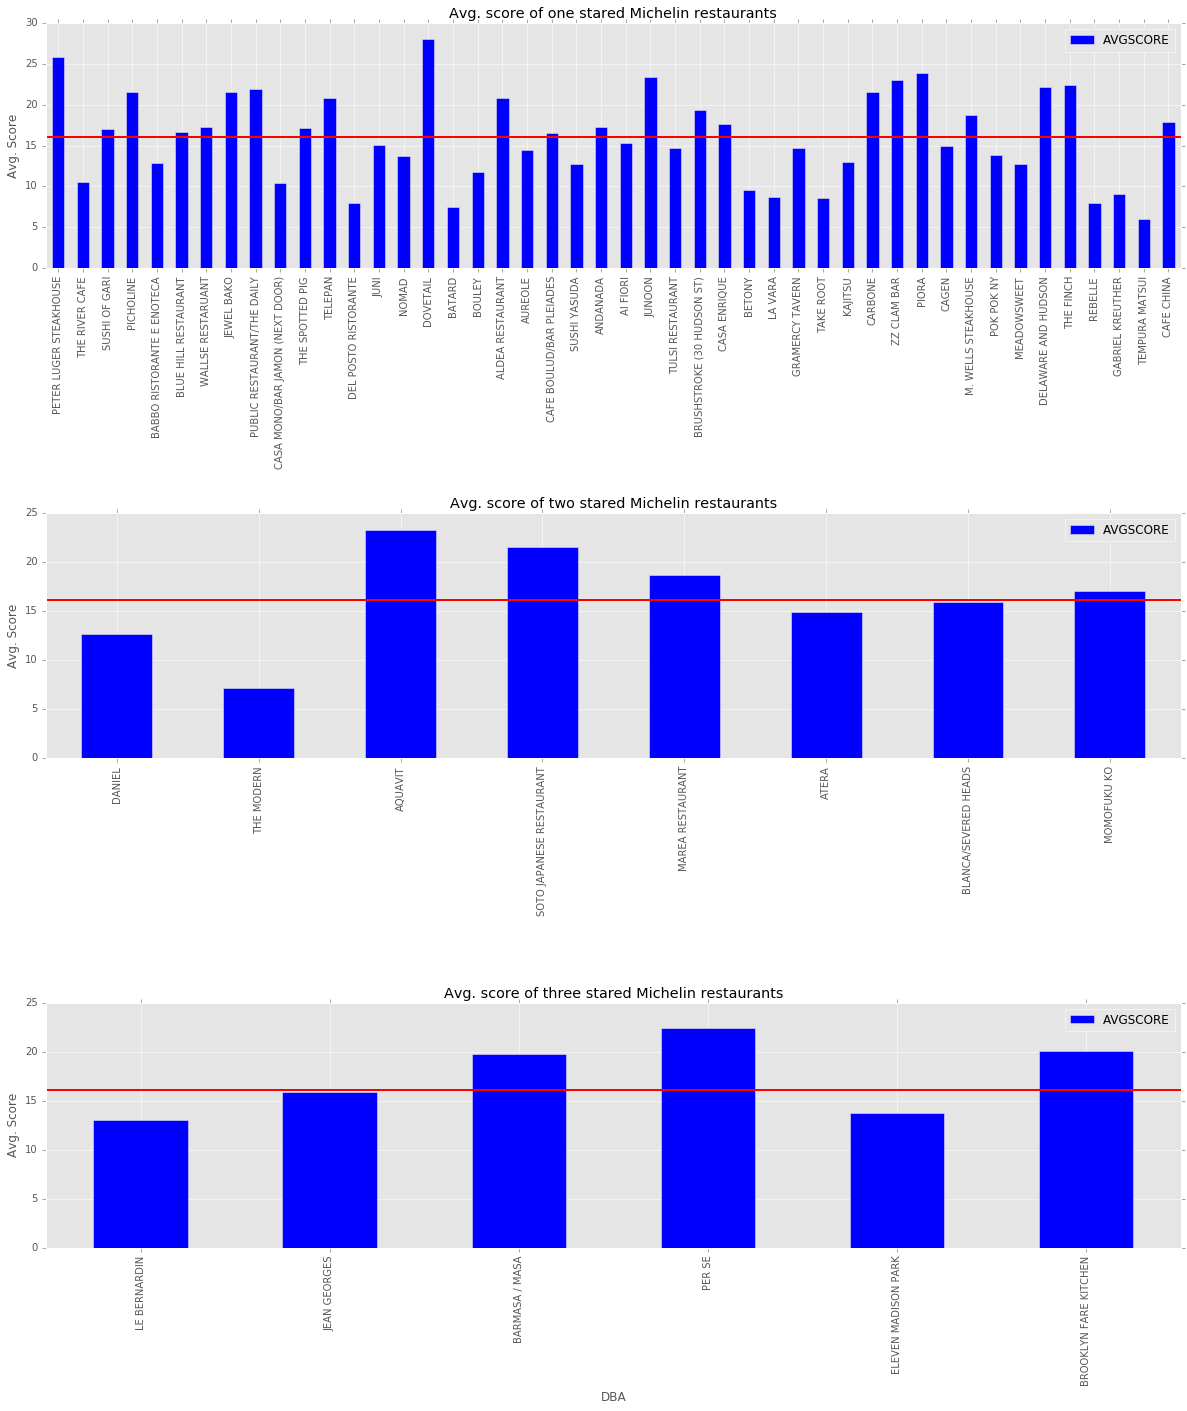

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=1)
fig.tight_layout()
fig.set_figheight(20)
fig.set_figwidth(18)
axes = axes.ravel()
data_1mich[['DBA','AVGSCORE']].plot(kind = "bar", x="DBA", y="AVGSCORE", ax=axes[0])
data_2mich[['DBA','AVGSCORE']].plot(kind = "bar", x="DBA", y="AVGSCORE", ax=axes[1])
data_3mich[['DBA','AVGSCORE']].plot(kind = "bar", x="DBA", y="AVGSCORE", ax=axes[2])
_ = axes[0].axhline(y=Mean, xmin=0, xmax=1,  c="red",linewidth=2)
_ = axes[1].axhline(y=Mean, xmin=0, xmax=1,  c="red",linewidth=2)
_ = axes[2].axhline(y=Mean, xmin=0, xmax=1,  c="red",linewidth=2)
_ = axes[0].set_ylabel('Avg. Score')
_ = axes[1].set_ylabel('Avg. Score')
_ = axes[2].set_ylabel('Avg. Score')
_ = axes[0].set_xlabel('')
_ = axes[1].set_xlabel('')
_ = axes[0].set_title('Avg. score of one stared Michelin restaurants')
_ = axes[1].set_title('Avg. score of two stared Michelin restaurants')
_ = axes[2].set_title('Avg. score of three stared Michelin restaurants')
plt.subplots_adjust(hspace = 1)

From this it is not clear whether it improves the score if you have a star. Let us do some calculations

In [22]:
perct_above_av=len(data_1mich[data_1mich['AVGSCORE'] > Mean])/len(data_1mich)
print"Percentage of 1 Michelin star restaurants having a score above average (thus a below average hygiene) %.4f"% perct_above_av
perct_above_av2=len(data_2mich[data_2mich['AVGSCORE'] > Mean])/len(data_2mich)
print"Percentage of 2 Michelin star restaurants having a score above average (thus a below average hygiene) %.4f"% perct_above_av2
len(data_2mich[data_2mich['AVGSCORE'] > Mean])
perct_above_av3=len(data_3mich[data_3mich['AVGSCORE'] > Mean])/len(data_3mich)
print"Percentage of 3 Michelin star restaurants having a score above average (thus a below average hygiene) %.4f"% perct_above_av3

Percentage of 1 Michelin star restaurants having a score above average (thus a below average hygiene) 0.5000
Percentage of 2 Michelin star restaurants having a score above average (thus a below average hygiene) 0.5000
Percentage of 3 Michelin star restaurants having a score above average (thus a below average hygiene) 0.5000


Very interesting. It doesn't matter whether you have 1, 2 or 3 three stars -  you really don't seem to be better or worse off.

In [23]:
Av_3s=np.mean(data_3mich['AVGSCORE'])
Av_2s=np.mean(data_2mich['AVGSCORE'])
Av_1s=np.mean(data_1mich['AVGSCORE'])
print "Average of three stared restaurants: ", Av_3s
print "Average of two stared restaurants: ", Av_2s
print "Average of one stared restaurants: ", Av_1s
print "Global overall mean: ", Mean

Average of three stared restaurants:  17.4963108119
Average of two stared restaurants:  16.3831396545
Average of one stared restaurants:  16.0671207112
Global overall mean:  16.1013482377


We see that the 1 star Michelin restaurants surprisingly have the best hygiene out of the three, and only slightly below the global mean.

#### 2.4.3 - Geographical information

At our website we have produced a very informative, interactive visualisation of the geographical information. The conclusion from this is that there tend to be better score at Manhattan and Bronx than other places in NYC. Let us try and see if we can reproduce such results here

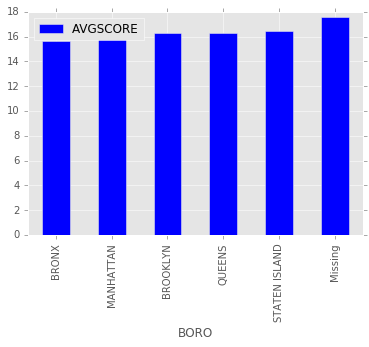

In [24]:
_ = df_unique[["BORO","AVGSCORE"]].groupby("BORO").mean().sort_values(["AVGSCORE"]).plot(kind = "bar", y="AVGSCORE")

We actually find the same here - Bronx and Manhattan seem to be the places to be if you like clean food. 

#### 2.4.4 - Exploring the Yelp dataset

We will explore the Yelp dataset in this section. Let's first investigate if there is a correlation between Yelp rating and the hygiene score. We consider only data with 5 or more reviews for a reliable grade and we log transform the review counts due to the skewed distribution.

In [25]:
df_score = df_unique[["AVGSCORE", "RATING_YELP", "REVIEW_COUNT_YELP"]][df_unique["REVIEW_COUNT_YELP"]>4]
df_score["LOG_REVIEW_COUNT_YELP"] = [math.log(float(s)) for s in df_score["REVIEW_COUNT_YELP"]]

In [26]:
df_score.corr()

,AVGSCORE,RATING_YELP,REVIEW_COUNT_YELP,LOG_REVIEW_COUNT_YELP
AVGSCORE,1.000000,0.009277,0.011192,-0.014888
RATING_YELP,0.009277,1.000000,0.125349,0.206441
REVIEW_COUNT_YELP,0.011192,0.125349,1.000000,0.567426
LOG_REVIEW_COUNT_YELP,-0.014888,0.206441,0.567426,1.000000


There does not seem to be any linear relationship between yelp scores and hygiene score.

The size of the Yelp dataset with a review count of five or more has significantly reduced our dataset

In [27]:
df_score.shape

(611, 4)

So we have a very small dataset by now. Two scatter plots are shown below the first with log review counts versus the average score and the second being the Yelp rating versus the average score. None of them seem to exhibit any obvious relationship.

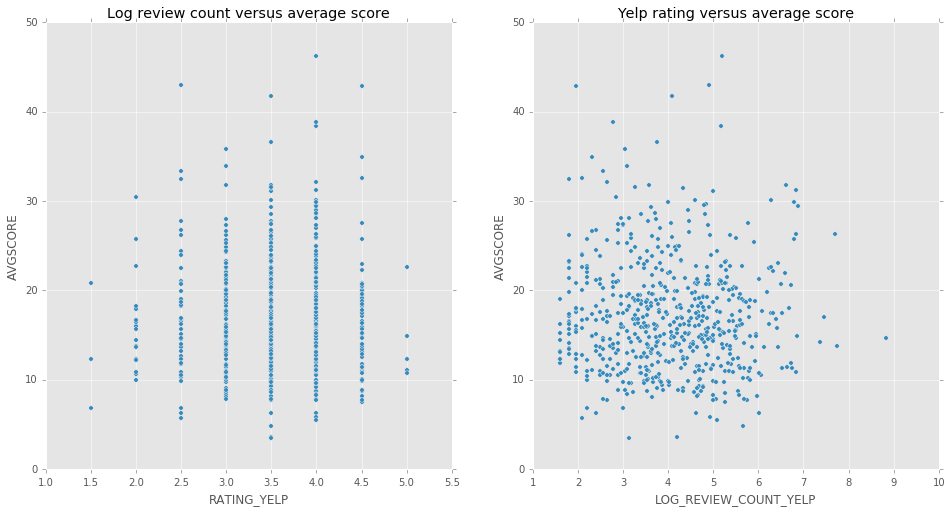

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes = axes.ravel()
fig.set_figheight(8)
fig.set_figwidth(16)
df_score.plot(kind='scatter', x='RATING_YELP', y='AVGSCORE', ax=axes[0])
df_score.plot(kind='scatter', x='LOG_REVIEW_COUNT_YELP', y='AVGSCORE', ax=axes[1])
_ = axes[1].set_title('Yelp rating versus average score')
_ = axes[0].set_title('Log review count versus average score')

Now let us define the dataset with all the information we need for building our models later on

In [29]:
df_pred_yelp = df_unique[["AVGSCORE", "RATING_YELP", "REVIEW_COUNT_YELP","CUISINE", "lat", "lon"]][df_unique["REVIEW_COUNT_YELP"]>4]
df_pred_yelp["LOG_REVIEW_COUNT_YELP"] = [math.log(float(s)) for s in df_score["REVIEW_COUNT_YELP"]]

To make sure that we haven't discarded any of the cuisines by now, and that all of the cuisiness have at least some observations let us plot it below. We see that the distribution is almost the same for those restaurants with a Yelp score and those without, but of course, with alot less observations. The average scores for those with a Yelp score are plotted in the lower most plot. Again, Asian and African cuisines seem to have the worst score.

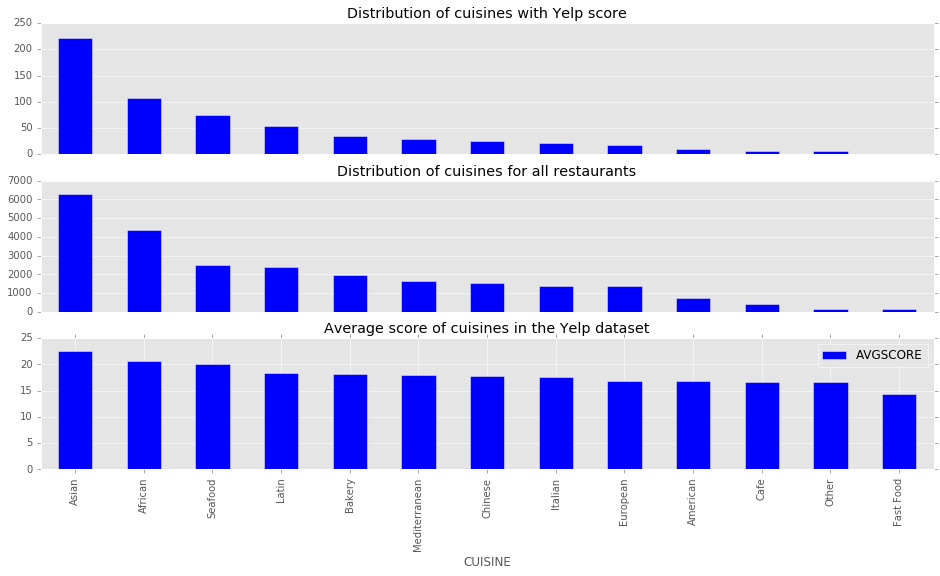

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=1)
axes = axes.ravel()
fig.set_figheight(8)
fig.set_figwidth(16)
df_pred_yelp['CUISINE'].value_counts().plot(kind = 'bar', ax=axes[0])
df_unique['CUISINE'].value_counts().plot(kind = 'bar', ax=axes[1])
df_pred_yelp[["CUISINE","AVGSCORE"]].groupby("CUISINE").mean().sort_values('AVGSCORE', ascending=False).plot(kind='bar', ax=axes[2])
axes[0].set_title('Distribution of cuisines with Yelp score')
axes[1].set_title('Distribution of cuisines for all restaurants')
axes[2].set_title('Average score of cuisines in the Yelp dataset')
_ = axes[0].get_xaxis().set_ticks([])
_ = axes[1].get_xaxis().set_ticks([])

## 3 - Theory

According to our statement of problem we would like to predict the average restaurant score based on the information available to the average tourist. We shall do this by various machine learning techniques which can be applied to a regression problem. Some reasonable models applicable to predict a continous output are:
- A random forest regression
- Multiple regression
- Regression tree
- Ada boost regression tree

These four models will all be applied to two different kind of problems:

- Predicting the average score **without** the Yelp dataset
- Predicting the average score **with** the Yelp dataset

We make this distinction since we do not have reliable Yelp data for all the restaurants in the Inspection dataset. Actually, we only have for 611 restaurants and due to the limiting size of this dataset we shall investigate both approaches. In either case we define a test and training dataset of 10% and 90%, respectively. For the categorical predictors we will apply a one-out-of-k-coding transformation prior to fitting the models as well as a suitable scaling of the numerical predictors.

The predictors we find interesting in the Inspection dataset, the Yelp dataset and the coordinates dataset are:

- Our own, modified cuisine type
- Lattitude
- Longitude
- Review Count
- Rating Yelp

And we will of course be trying to predict the score for each restaurant averaged over the inspections for the restaurant of interest.

For those models where it makes sense, we will do some statistical inference on the predictors, hopefully making it possible to determine which features are most important in determining where it is safe to eat in New York City.

Notice that we disregard the Michelin data here. First because of the low number of restaurants actually having one and secondly  because there really wasn't anythint interesting going on as seen from the initial investigation.

### 3.1 - Machine learning theory

We here very briefly outline some of the theory behind the methods that be intend to use. In the following we denote by $y_i$ the observed response (i.e. the score of the $i$th observation) and by $x_i=(x_{i1},\dots,x_{id})$ the input observation (i.e. that latitude, longitude, and so on). 

** Multiple linear regression **

In multiple linear regression the model may be written
$$f(x_i)=\beta_0 + \sum_{j=1}^d \beta_{j} x_{ij} $$
It is thus assumed that the observed reponse is related linearly to the inputs plus some Gaussian noise
$$f(x_i) = y_i + \epsilon_i, \quad \epsilon \overset{i.i.d.}{\sim} \mathcal{N}(0,\sigma^2)$$
The model parameters are estimated by minimising the sum of squared residuals $\sum_i(f(x_i)-y_i)^2$ which has a well-known closed form solution. The advantage of the multiple linear regression model lies in its simplicity.

** Regression Tree **

Regression trees work by partitioning the feature space into a set of disjoint regions $R_1,\dots,R_K$ that are cubes. For each region we then use the average of the points within the region for prediction. In this way the regression tree model is defined by
$$f(x) = \mathrm{ave}(y\,|\,x \in R_k) \quad \mathrm{if} \quad x\in R_k$$
The regions are selected in a greedy fashion aiming to minimise sum of squares
$$\sum_{i}(y_i-f(x))^2$$
The main advantages of a regression tree is its simple interpretabiliy and the few assumptions needed. Its disadvantages are the requirement of splitting the feature sapce into cubes and the fact that it is easy to overfit. 

** Random Forest **

A random forest is as the name suggests as forrest of regression trees that combined should give a better model than the individual trees. The idea is to fit many overfitted (low bias, high variance) trees on different data sets denoted yielding the $B$ tree models $f^{1}(x),\dots,f^B(x)$. The random forrest model then just takes an average of all of the trees to form a single output
$$f(x) = \frac{1}{B}\sum_{b=1}^B f^b(x)$$
Since taking an average of distinct variables will reduce the variance (at least if they are not perfectly correlated), we hope to end up with a low bais and low variance model.

Of course we only have a single data set, but we can form new data sets using bootstrapping. To ensure that the trees fitted on each data set are somewhat distinct (i.e. decorrelated) we randomly sample a subset of features to be used in fitting each of the trees. 

The disadvantage of the random forrest is that we lose the easy interpretability of the simple regression tree.

** Ada Boost Regression Tree **

An Adaboost regression tree is a alternative way to combine models to achieve an even better model. The strategy of Adaboost trees is to build simple models (high bias, low variance) and then attempt to reduce the bias. This is done by sequentially fitting trees, each time trying to improve on the previously fitted tree.

### 3.2 - Predicting by use of Yelp dataset

**Initial data manipulation**

A snippet of the dataset to be used is shown below

In [31]:
df_pred_yelp.head()

,AVGSCORE,RATING_YELP,REVIEW_COUNT_YELP,CUISINE,lat,lon,LOG_REVIEW_COUNT_YELP
0,19.333333,4.5,22,Bakery,40.848432,-73.856035,3.091042
33,9.666667,3.5,39,European,40.767821,-73.984981,3.663562
42,5.666667,2.5,8,American,40.579505,-73.982420,2.079442
74,17.826087,3.5,122,Other,40.619893,-73.906840,4.804021
110,8.111111,3.5,387,American,40.850288,-73.878611,5.958425


In [32]:
print "Size of dataset: ", df_pred_yelp.shape

Size of dataset:  (611, 7)


In order to use the models previously mentioned we apply the one-out-of-k-coding to the cuisine description of the dataset

In [33]:
df_pred_yelp = pd.get_dummies(df_pred_yelp, columns =['CUISINE'])

The last thing we need in order to be able to apply the models is to define the test and traning dataset and also scale the numerical variables. We drop the review count, since we now use the log-transformed count.

In [34]:
y = df_pred_yelp['AVGSCORE']
X = df_pred_yelp.drop(['AVGSCORE','REVIEW_COUNT_YELP'], axis=1)

Below we scale the numeric predictors as well as the response variable such that they have zero mean and a standard deviation of one.

In [35]:
X[['RATING_YELP','lat','lon','LOG_REVIEW_COUNT_YELP']] = preprocessing.scale(X[['RATING_YELP','lat','lon','LOG_REVIEW_COUNT_YELP']])

And we may now define the test and traning sets. We make a simple split into a training dataset consisting of 90% of the observations and a testset consisting of the remaining 10%.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
print "Size of training X: ", X_train.shape
print "Size of test X: ", X_test.shape
print "Size of training Y: ", y_train.shape
print "Size of test Y: ", y_test.shape

Size of training X:  (549, 17)
Size of test X:  (62, 17)
Size of training Y:  (549L,)
Size of test Y:  (62L,)


We also define a function to calculate the $R^2$ for the different models

In [37]:
def r_squared(y_obs, y_fit):
    sst = sum((y_obs - np.mean(y_obs))**2)
    ssr = sum((y_obs - y_fit)**2)
    return 1 - ssr / sst

And we wrap this is in a function that retrieves the mean squared error as well as the $R^2$ for a model

In [38]:
def get_score(fit, X_test, y_test):
    r2 = r_squared(y_test, fit.predict(X_test))
    mse = np.mean((y_test - fit.predict(X_test))**2)
    print "R2: ", r2
    print "MSE: ", mse

For the three regression forrest models previous mentioned it is possible to extract the feature importance, ie. how much this particular feature has had a say in the prediction. We define the below function for easy extraction later on. The random forrest method fits **n_estimators** numbers of forrests and we may therefore calculate the standard error of the feature importance. We do this if **plot = True** and plot them with red whiskers in a bar plot.

In [39]:
def get_importance_forest(fit, plot = False):
    importances = fit.feature_importances_

    indices = np.argsort(importances)[::-1]

    col_names = list(X_train.columns.values)

    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %s (No. %d) (%f)" % (f + 1, col_names[indices[f]], indices[f], importances[indices[f]]))
    
    # Only applicable for the random forrest method
    if plot:
        std = np.std([tree.feature_importances_ for tree in fit.estimators_], axis=0)
        plt.figure()
        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), importances[indices],
               color="b", yerr=std[indices], align="center")
        plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()

**Random forest**

We fit a random forest regressor that fits several trees (here controlled by the parameter n_estimator) and then averages across these trees in order to avoid over-fitting but also to improve prediction power.

In [40]:
forest_1 = RandomForestRegressor(n_estimators=1000, criterion = "mse", max_features = "auto",
                            oob_score = True, n_jobs = -1, max_depth = 2)
_ = forest_1.fit(X_train, y_train) # Save in unused variable to suppres output

forest_2 = RandomForestRegressor(n_estimators=1000, criterion = "mse", max_features = "auto",
                            oob_score = True, n_jobs = -1, max_depth = 5)
_ = forest_2.fit(X_train, y_train) # Save in unused variable to suppres output

Having fitted the model allows us to calculate the $R^2$ as well as the mean squared error.

In [41]:
print "Score for simple random forrest:"
get_score(forest_1, X_test, y_test)
print "Score for complex random forrest:"
get_score(forest_2, X_test, y_test)

Score for simple random forrest:
R2:  0.104404015134
MSE:  43.2290441609
Score for complex random forrest:
R2:  0.079748261404
MSE:  44.4191395665


Here we notice that the simpler model outperforms the more complex model, so we shall proceed with the simpler one.

For the random forrest regressor we are also able to quantify which of the features had most influence in predicting the score. This can be extracted from the forest object and since we have estimated a 1000 forrests we may calculate the standard error for each of the feature importance scores. We print this together with the 'importance' score. This is also plotted in the figure below where the red whiskers indicate the standard error.

Feature ranking:
1. feature CUISINE_Asian (No. 6) (0.339191)
2. feature lon (No. 2) (0.177243)
3. feature CUISINE_Fast Food (No. 11) (0.165958)
4. feature lat (No. 1) (0.145731)
5. feature LOG_REVIEW_COUNT_YELP (No. 3) (0.101991)
6. feature CUISINE_Seafood (No. 16) (0.030672)
7. feature RATING_YELP (No. 0) (0.024750)
8. feature CUISINE_Latin (No. 13) (0.005969)
9. feature CUISINE_American (No. 5) (0.004454)
10. feature CUISINE_Cafe (No. 8) (0.001884)
11. feature CUISINE_Mediterranean (No. 14) (0.001345)
12. feature CUISINE_Italian (No. 12) (0.000476)
13. feature CUISINE_European (No. 10) (0.000176)
14. feature CUISINE_Bakery (No. 7) (0.000160)
15. feature CUISINE_Chinese (No. 9) (0.000000)
16. feature CUISINE_Other (No. 15) (0.000000)
17. feature CUISINE_African (No. 4) (0.000000)


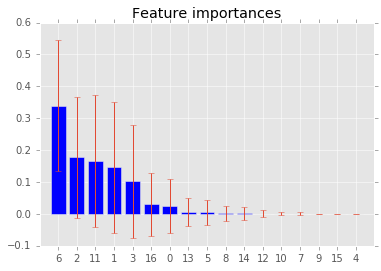

In [42]:
get_importance_forest(forest_1, plot=True)

Here we find that the most important cuisine types are Asian and Fast Food, indicating that if you know that the restaurant serves Asian food you can be pretty sure that it has a bad score and vice versa for fast food. The location of the restaurants also play an important role in determining where to eat safe and you should stay at Manhattan or Bronx if you want to be sure to eat safe as we see from the choropleth map at our website. It should, however, be noted that the standard errors are very high. This is probably due to the small number of observations in our dataset.

**Multiple regression**

An easy interpretable model is the multiple regression model. Below we fit this model in scikit-learn.

In [43]:
lr = LinearRegression()
_ = lr.fit(X_train, y_train)

And we are then able to calculate the $R^2$ and the MSE as previously

In [44]:
get_score(lr, X_test, y_test)

R2:  0.0944885896343
MSE:  43.7076465375


We notice that we in this case get a postive $R^2$ value, so the linear regression model may explain more than just a constant prediciton, but it has a worse score than the random forrest regressor.

**Decision Tree Regression**

Below we fit two decision trees: one simple and one complex with a maximum depth of 2 and 5, respectively.

In [45]:
# Fit regression models
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Scores
print "Scores for simple fit: "
get_score(regr_1, X_test, y_test)
print "\n"
print "Scores for complex fit: "
get_score(regr_2, X_test, y_test)

Scores for simple fit: 
R2:  0.104936705479
MSE:  43.2033320152


Scores for complex fit: 
R2:  -0.262079388029
MSE:  60.9186357706


It is quite easily seen that the complex model tends to overfit, while the simple model performs almost identical to the random forrest.

The feature importance can again be extracted from this tree as below. We notice that the asian and fast food cuisine again is important in predicting the score, while the position of the restaurant has dropped some ranks compared to the random forrest.

In [46]:
get_importance_forest(regr_1)

Feature ranking:
1. feature CUISINE_Asian (No. 6) (0.488091)
2. feature CUISINE_Fast Food (No. 11) (0.261702)
3. feature lon (No. 2) (0.250207)
4. feature CUISINE_Seafood (No. 16) (0.000000)
5. feature CUISINE_Bakery (No. 7) (0.000000)
6. feature lat (No. 1) (0.000000)
7. feature LOG_REVIEW_COUNT_YELP (No. 3) (0.000000)
8. feature CUISINE_African (No. 4) (0.000000)
9. feature CUISINE_American (No. 5) (0.000000)
10. feature CUISINE_Cafe (No. 8) (0.000000)
11. feature CUISINE_Other (No. 15) (0.000000)
12. feature CUISINE_Chinese (No. 9) (0.000000)
13. feature CUISINE_European (No. 10) (0.000000)
14. feature CUISINE_Italian (No. 12) (0.000000)
15. feature CUISINE_Latin (No. 13) (0.000000)
16. feature CUISINE_Mediterranean (No. 14) (0.000000)
17. feature RATING_YELP (No. 0) (0.000000)


We are able to plot the decision rules for these trees. First we export the struture in a .dot format

In [ ]:
tree.export_graphviz(regr_1, out_file='tree.dot')
tree.export_graphviz(regr_2, out_file='tree2.dot')

Then create PDF version using Graphviz dot:

*dot -Tpdf iris.dot -o iris.pdf*

(Remember to install graphviz and put it in your Path or cd into installation folder of Graphviz)

And we may now display it below

In [3]:
IFrame("./tree.pdf", width=800, height=500)

This is of course in alignment with the above conclusion. Below we show the same tree structure for the complex model for the sake of interest.

In [4]:
IFrame("./tree2.pdf", width=800, height=500)

**Ada boost Tree Regression**

We fit an AdaBoost Regressor

In [47]:
regr_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2),
                          n_estimators=300, random_state=123)

_ = regr_ada.fit(X_train, y_train)

And compute the scores

In [48]:
get_score(regr_ada, X_test, y_test)

R2:  -0.0236136536845
MSE:  49.4082606293


This model performs very poorly compared to the other trees, probably owing to overfitting. The important features for this model are

In [49]:
get_importance_forest(regr_ada)

Feature ranking:
1. feature LOG_REVIEW_COUNT_YELP (No. 3) (0.273390)
2. feature lon (No. 2) (0.241288)
3. feature lat (No. 1) (0.184869)
4. feature CUISINE_Asian (No. 6) (0.172479)
5. feature RATING_YELP (No. 0) (0.061263)
6. feature CUISINE_Fast Food (No. 11) (0.044013)
7. feature CUISINE_Seafood (No. 16) (0.022698)
8. feature CUISINE_Chinese (No. 9) (0.000000)
9. feature CUISINE_Other (No. 15) (0.000000)
10. feature CUISINE_Bakery (No. 7) (0.000000)
11. feature CUISINE_European (No. 10) (0.000000)
12. feature CUISINE_American (No. 5) (0.000000)
13. feature CUISINE_African (No. 4) (0.000000)
14. feature CUISINE_Italian (No. 12) (0.000000)
15. feature CUISINE_Latin (No. 13) (0.000000)
16. feature CUISINE_Mediterranean (No. 14) (0.000000)
17. feature CUISINE_Cafe (No. 8) (0.000000)


Where we find that the location still is important, but now the review count also has some say.

### 3.1 - Conclusion on Yelp dataset

It is fairly easy to come to the conclusion that none of the above models are very good at predicting the average restaurant scores based on all our datasets available. The best model was the simple regression tree with a maximum depth of two. This model achieved an $R^2$ of 0.10 and MSE of 43, which is slightly above just a constant guess. This may be due to the very small sample for the Yelp dataset. The interesting part of this analysis is, however, that we have gained some insight in which features may be able to help a consumer that wants to find a safe place to eat. We will try to avoid concluding on the features that are not in the Yelp dataset, since these may change in the subsequent analysis. However, for the models that actually did make some sense (random forrest and the decision tree) we really didn't find any evidence for the Yelp score nor the number of reviews to be able to predict the average inspection score. This is also what we infered from the explorative plotting. So if you are a tourist in NYC concerned about eating in a safe and clean restaurant, you can't rely on the Yelp score or the number of reviews for any guidance.

### 3.3 - Predicting scores without Yelp

In this section we will try to predict the scores without the use of the Yelp dataset. As previously argued we do this since this drastically increases the number of observations in the dataset.

**Initial data manipulation**

In alignment with what we previously did, we apply a one-out-of-k-coding to the cuisine variable as well as scale the numerical inputs lat and long and lastly define the traning and test dataset. We shall only cover the methods briefly here, since this basically is just a repeatment of what has previously been done.

In [50]:
df_pred = df_unique[["AVGSCORE","lat","lon", "CUISINE"]]
X = df_pred.drop("AVGSCORE", axis=1)
y = df_pred["AVGSCORE"]
X[['lat','lon']] = preprocessing.scale(X[['lat','lon']])
X = pd.get_dummies(X, columns =['CUISINE'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(22389, 15) (2488, 15) (22389L,) (2488L,)


Notice the increase in observations.

**Random forest**

In [51]:
forest_1 = RandomForestRegressor(n_estimators=1000, criterion = "mse", max_features = "auto",
                            oob_score = True, n_jobs = -1, max_depth = 2)
_ = forest_1.fit(X_train, y_train) # Save in unused variable to suppres output

forest_2 = RandomForestRegressor(n_estimators=1000, criterion = "mse", max_features = "auto",
                            oob_score = True, n_jobs = -1, max_depth = 5)
_ = forest_2.fit(X_train, y_train) # Save in unused variable to suppres output


print "Scores for simple random forrest: "
get_score(forest_1, X_test, y_test)
print "\n"
print "Scores for complex random forrest: "
get_score(forest_2, X_test, y_test)

Scores for simple random forrest: 
R2:  0.0148414655723
MSE:  55.5545218933


Scores for complex random forrest: 
R2:  0.0373170430801
MSE:  54.2870914046


So now we actually see the more complex tree predicts better. Let us try to let the algorithm choose the depth automatically

In [52]:
forest_3 = RandomForestRegressor(n_estimators=1000, criterion = "mse", max_features = "auto",
                            oob_score = True, n_jobs = -1, max_depth = None)
_ = forest_3.fit(X_train, y_train) # Save in unused variable to suppres output


print "Scores for random forrest: "
get_score(forest_3, X_test, y_test)

Scores for random forrest: 
R2:  -0.0907642471308
MSE:  61.5097815529


This gets worse. Let us go with *max_depth = 5*.

Feature ranking:
1. feature CUISINE_Other (No. 13) (0.203517)
2. feature CUISINE_Cafe (No. 6) (0.203294)
3. feature lat (No. 0) (0.178714)
4. feature CUISINE_American (No. 3) (0.167698)
5. feature lon (No. 1) (0.161673)
6. feature CUISINE_Fast Food (No. 9) (0.065530)
7. feature CUISINE_Bakery (No. 5) (0.015352)
8. feature CUISINE_Chinese (No. 7) (0.002348)
9. feature CUISINE_Latin (No. 11) (0.000896)
10. feature CUISINE_African (No. 2) (0.000291)
11. feature CUISINE_Seafood (No. 14) (0.000261)
12. feature CUISINE_European (No. 8) (0.000169)
13. feature CUISINE_Asian (No. 4) (0.000125)
14. feature CUISINE_Italian (No. 10) (0.000098)
15. feature CUISINE_Mediterranean (No. 12) (0.000032)


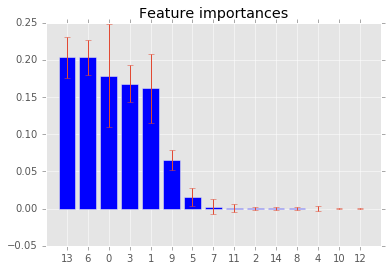

In [53]:
get_importance_forest(forest_2, plot = True)

Okay, so now we see that it is the cafés and other cuisines that are important in determining the score. As we previously saw these had a very good score, so this makes good sense. Knowing that the cuisine description is either café or other may be a good idea, since you then are pretty sure that they serve safe food. The standard errors are also much smaller now, due to the larger dataset.

**Linear regression**

In [54]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print "Score for linear regression: "
get_score(lr, X_train, y_train)

Score for linear regression: 
R2:  0.0370002161012
MSE:  58.6958734571


The linear regression performs worse than our decision tree. So we shall not consider this further. 

**Regression trees**

In [55]:
# Fit regression models
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Scores
print "Scores for simple fit: "
get_score(regr_1, X_test, y_test)
print "\n"
print "Scores for complex fit: "
get_score(regr_2, X_test, y_test)

# Feature importance
print "\n"
get_importance_forest(regr_2)

Scores for simple fit: 
R2:  0.0137473948545
MSE:  55.6162181315


Scores for complex fit: 
R2:  0.0278341746325
MSE:  54.8218441417


Feature ranking:
1. feature CUISINE_Other (No. 13) (0.238022)
2. feature CUISINE_Cafe (No. 6) (0.203117)
3. feature CUISINE_American (No. 3) (0.183402)
4. feature lat (No. 0) (0.151830)
5. feature lon (No. 1) (0.133202)
6. feature CUISINE_Fast Food (No. 9) (0.070520)
7. feature CUISINE_Bakery (No. 5) (0.019907)
8. feature CUISINE_Seafood (No. 14) (0.000000)
9. feature CUISINE_Mediterranean (No. 12) (0.000000)
10. feature CUISINE_Latin (No. 11) (0.000000)
11. feature CUISINE_Italian (No. 10) (0.000000)
12. feature CUISINE_European (No. 8) (0.000000)
13. feature CUISINE_Chinese (No. 7) (0.000000)
14. feature CUISINE_Asian (No. 4) (0.000000)
15. feature CUISINE_African (No. 2) (0.000000)


In [55]:
# View in notebook
IFrame("./tree3.pdf", width=800, height=500)

The conclusion is almost identical to the random forrest. It is worthwhile knowing if the cuisine is in the category other, cafe or american, and it also helps to know where the restaurant is located.

**Adaboost regression**

In [56]:
regr_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2),
                          n_estimators=300, random_state=123)

regr_ada.fit(X_train, y_train)

print "Score for AdaBoost regression: "
get_score(regr_ada, X_test, y_test)
print "\n"
get_importance_forest(regr_ada)

Score for AdaBoost regression: 
R2:  -0.206609518856
MSE:  68.0424648312


Feature ranking:
1. feature lon (No. 1) (0.373018)
2. feature CUISINE_Other (No. 13) (0.222749)
3. feature lat (No. 0) (0.187304)
4. feature CUISINE_Cafe (No. 6) (0.153972)
5. feature CUISINE_African (No. 2) (0.049938)
6. feature CUISINE_American (No. 3) (0.010831)
7. feature CUISINE_Seafood (No. 14) (0.002115)
8. feature CUISINE_Asian (No. 4) (0.000074)
9. feature CUISINE_Mediterranean (No. 12) (0.000000)
10. feature CUISINE_Latin (No. 11) (0.000000)
11. feature CUISINE_Italian (No. 10) (0.000000)
12. feature CUISINE_Fast Food (No. 9) (0.000000)
13. feature CUISINE_European (No. 8) (0.000000)
14. feature CUISINE_Chinese (No. 7) (0.000000)
15. feature CUISINE_Bakery (No. 5) (0.000000)


The adaboost regression also performs poorly on this dataset, so we shall not consider this further.

### 3.1 - Conclusion on predicting scores without Yelp

When we disregard the Yelp dataset, the number of observations increases significantly. This enables us to make more robust conclusion about the features *lattitude*, *longitude* and *cuisine*. The random forest regressor and the regression tree performed best on this dataset. Both showed that the two cuisine types Other and Cafe were important in predicting the average inspection score, so our tourist can be certain that these cuisine types serve safe food. The lattitude also scored higher in both regressors than the longitude, but also the longitude had some impact. Thus, we may conclude that the location actually helps in predicting the score and you should probably stay on Manhattan to be on the safe side. Conclusively,<b> we may say that for a tourist it is helpfull to know whether the restaurant is in the category Other or Cafe, and if they are, this probably means that there is a low chance of catching some sort of sickness as seen from the investigative plotting.</b> On the other hand, these cuisines really aren't that interesting. So we also find that knowing if the cuisine type is American also helps in the prediction. As we saw in the investigative section this type of cuisine was also associated with a low score. Therefore,<b> knowing a restaurant serves American food tells our tourist that it is a somewhat safe place to eat. </b>

## 4 - Visualizations

At the website http://castaberi.github.io/ we provide a small, non-technical overview of this entire project. We have provided three D3 visualisations, which all aim to make the investigation of our datasets easier, fun and visually pleasing. In this section we explain why we have chosen these particular visualisations.

### 4.1 D3 visualisation #1 - Geographical information

The location of the restaurant is one of the main features in our dataset. We find it interesting to know whether the location in NYC actually has a say in whether the hygiene of this restaurant is percieved as good. Hence, we visualise this in a choropleth map. The user has the opportunity to switch between the number of restaurants colored accordingly in a region or see the average score within this region. This enables the user to get a quick and informative overview of i) where the majority of restaurants actually are and ii) how the inspection scores are distributed. Hovering over a specific region reveals the frequency, the average score as well as the region name and zip code. With such an interactive visualisation we believe that the user gain an important insight into geographical information of our dataset.

### 4.2 D3 visualisation #2 - Cuisine types

The type of cuisine is another, very important feature in our dataset. So it is naturally to also visualise this at our website. We do this by showing the distribution across the 13 different cuisines, allowing the user to visualise which kind of cuisines are most frequent in NYC. We also allow for a toggle option. Here, we show how the average cuisine score is compared to the other and also the overall average indicated by a dashed, black line. By showing this plot, we hope that the reader easily gains insight into how the different cuisines score, which is a crucial part of our assignment and modelling phase.

### 4.3 D3 visualisation #3 - User reviews

The third and last important feature is the Yelp score. Before we carried out our analysis we thought we would find a clear relationship between the Yelp score and the average inspection score. It turns out that this realationship is non-exicisting. As this came as a suprise to us, we find it interesting to display to our readers as well. We have enabled a dropdown list, so the reader can switch between the 13 different cuisines to see the relationship for themselves. By showing this visualisation we hope to persuade the reader that there do not exists a relationship.

## 5 - Discussion (Conclusion)

Throughout this report we have explored several different aspects of the dataset containing a list of restaurant inspections in New York City. Our aim and perspective has been Health, but we have also explored the correlation between public opinion and scoring by looking at data form Yelp and Restaurants with Michelin Stars. 

This notebook is meant to complement our website <a href="http://castaberi.github.io">GITHUB LINK</a> and is a follow-up to our video https://www.youtube.com/watch?v=Y_DVouPSDXM.

Some interesting conclusions can be drawn from our analysis. These include

<ul>
  <li>The average scores of restaurants vary largely among the different cuisine types. On average, Cafés perform very well, while African, Asian and other foreign cuisine types tend to score poorly. As mentioned earlier this can be because of different preparation techniques that involve more hand contact or cooking at low/without heat. For instance, there are strict regulations for making sushi or other raw foods which can be particularly penalising for Asian cuisine. Overall, if hygiene is a high priority then a <b>café would be a wise choice </b> and if you are into something a bit more interesting go for the <b> american serving restaurants </b></li>
 <br> <br>
<li> The general opinion of taste and good restaurants can be unrelated to the overall hygiene of the restaurant. As we saw with the three star Michelin restaurants, where the average score lay higher than the overall average. An example that stands out is the three star restaurant PER SE.<a href=" https://en.wikipedia.org/wiki/Per_Se_(restaurant)">Wikipedia </a> has the following to say about Per Se *“Per Se is currently the third most expensive restaurant in the world… with an average guest spending approximately $851”* however we can see that this restaurant has an average score of 22.4 which is significantly higher than the average. Thus, <b> public opinion and health inspections don't necessarily have the same thoughts on excellence </b>
</li>
<br><br>
<li>
 In Part 3 of this report, we looked into machine learning methods for predicting the score of a restaurant using various features. We used our dataset and some data collected from the website Yelp. The size of the data that could be retrieved through yelp was quite small which made the standard errors very big. We ran two separate sets of tests on the smaller sized dataset including data from Yelp and one on the dataset without data from Yelp. <b> There seems to be no obvious relationship between the Yelp score and the inspection score </b>, so don't waste your time checking out the Yelp score, if you are concerned with finding a safe place to eat in NYC. On the other hand, you should definetely know which kind of cuisine type the restaurant belongs to. Especially the <b> Cafe, Other and American </b> cuisine types turned out to have an impact on the prediction. If you also know where the restaurant is <b> located </b> you should have a fair chance of not getting a disease if you choose your restaurant based on these conclusions.
<br><br>
</li>


<b>Advice for Tourists in New York City</b>
<br><br>
If you plan to go to NYC make sure you know <b> where </b> the restaurant is placed, what kind of <b> cuisine description </b> they belong to and do not bother checking out the Yelp.com website!
<br><br>

<b> Thoughts on the process </b>
<br><br>
Overall we think that our end goal has been reached. We are able to provide some very specific suggestions to a tourist in NYC with limited information about where he or she is going to eat. Most of the process went well, but we could definetely improve on some aspects of the analysis. We do think that having access to more detailed information about each restaurant would have been helpful. Imagine a dataset where we also had access to price-range, revenue, # of employees etc. Such features would have been very interesting to look at and we could broaden our analysis considerably. This would perhaps also overcome the issue of the modelling phase, where we saw that we weren't able to explain as much of the variation as we would have liked. Another issue has been the size of the Yelp data retrieved. Have we gained access to even more, we would have been able to come up with more robust conclusions in this section.
</ul>

